In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


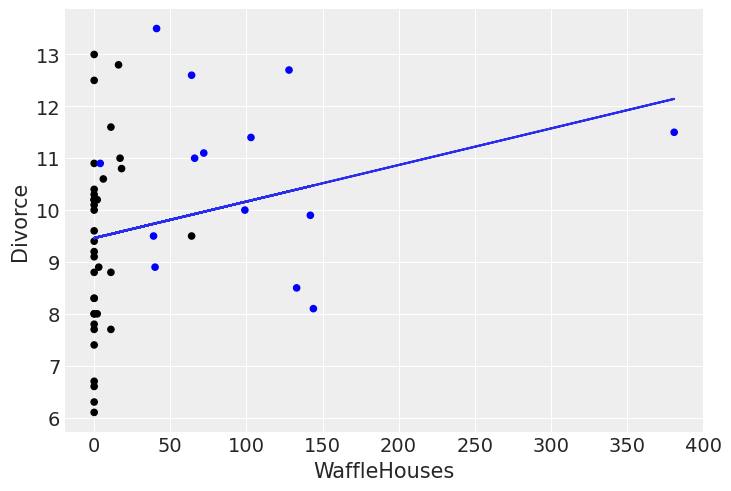

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'b' if x == 1 else 'k')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_M \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 11 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta_M'}>,
        <AxesSubplot:title={'center':'beta_M'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

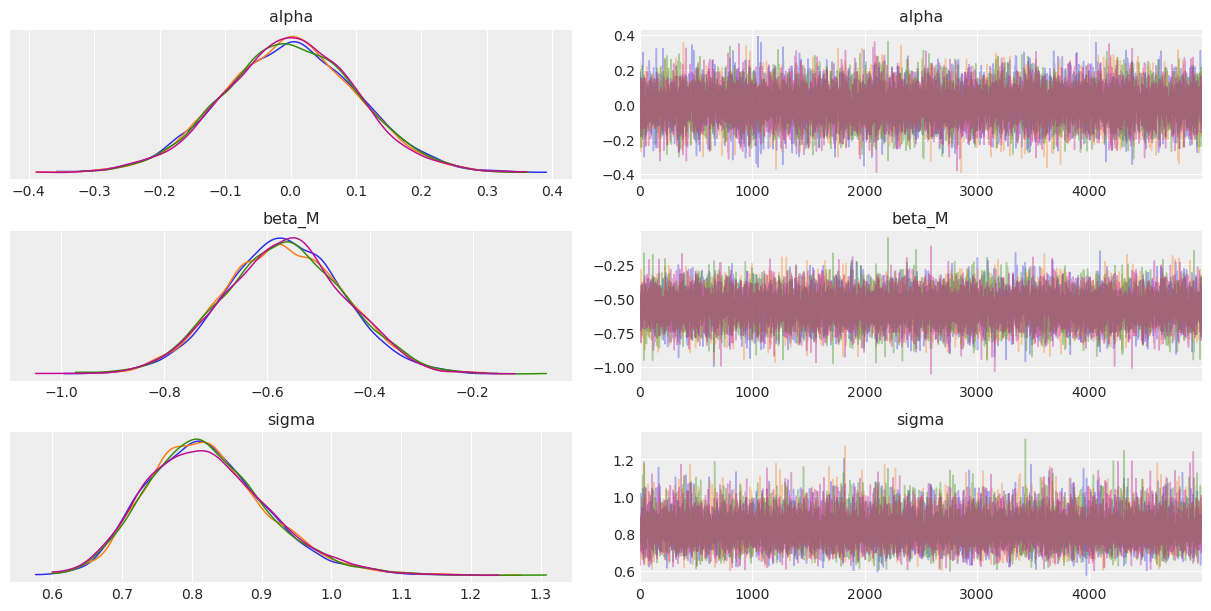

In [7]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_M', 'sigma'])

In [8]:
df_trace = pm.trace_to_dataframe(trace_5_1)
df_trace.head()

,alpha,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.164182,-0.544857,0.752834,0.166159,0.209971,-0.052900,0.604277,-0.491018,-0.009088,-0.841512,...,0.034724,0.209971,0.209971,1.042395,-0.534829,-0.315770,-0.096712,0.297595,-0.271959,0.648089
1,-0.097693,-0.443019,0.724811,0.170905,0.206528,-0.007210,0.527135,-0.363441,0.028413,-0.648425,...,0.064036,0.206528,0.206528,0.883366,-0.399064,-0.220949,-0.042833,0.277774,-0.185326,0.562758
2,0.154741,-0.676907,0.923567,0.565143,0.619573,0.292993,1.109442,-0.251306,0.347423,-0.686745,...,0.401853,0.619573,0.619573,1.653741,-0.305736,-0.033586,0.238563,0.728433,0.020844,1.163872
3,0.184085,-0.450408,0.816679,0.457163,0.493380,0.276076,0.819335,-0.086096,0.312294,-0.375834,...,0.348511,0.493380,0.493380,1.181507,-0.122313,0.058773,0.239859,0.565814,0.094990,0.855552
4,0.159841,-0.512377,0.847580,0.470490,0.511690,0.264489,0.882491,-0.147512,0.305690,-0.477113,...,0.346890,0.511690,0.511690,1.294492,-0.188712,0.017289,0.223289,0.594090,0.058489,0.923691


In [9]:
df_mu = df_trace.filter(regex=('mu.*'))
mu_mean = df_mu.apply(np.mean, axis=0)

In [10]:
mu_mean.values.shape

(50,)

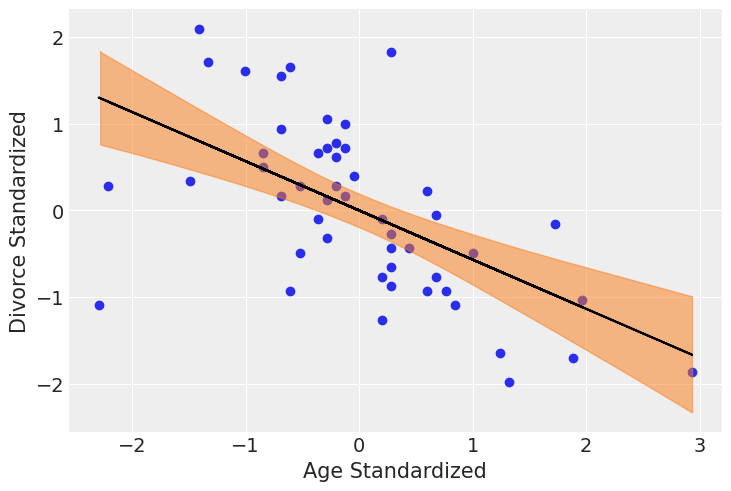

In [11]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()